In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import CustomGenerator
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
import importlib
importlib.reload(CustomGenerator)
from CustomGenerator import ReturnsDataGen, CodeBookDataGen

In [3]:
# Load data
data = np.load('master_data/data.npy')
train_batches = data.shape[0] # N hereafter. Number of training images in database.
length = data.shape[1] 
stocks = data.shape[2]
print('Number of training batches: ', train_batches)
print('Length of each batch: ', length)
print('Number of stocks: ', stocks)
data.shape

Number of training batches:  189
Length of each batch:  250
Number of stocks:  363


(189, 250, 363)

In [4]:
data_gen = ReturnsDataGen(data)

Number of training batches:  189
Length of each batch:  250
Number of stocks:  363


In [5]:
type(data[0,0,0])

numpy.float64

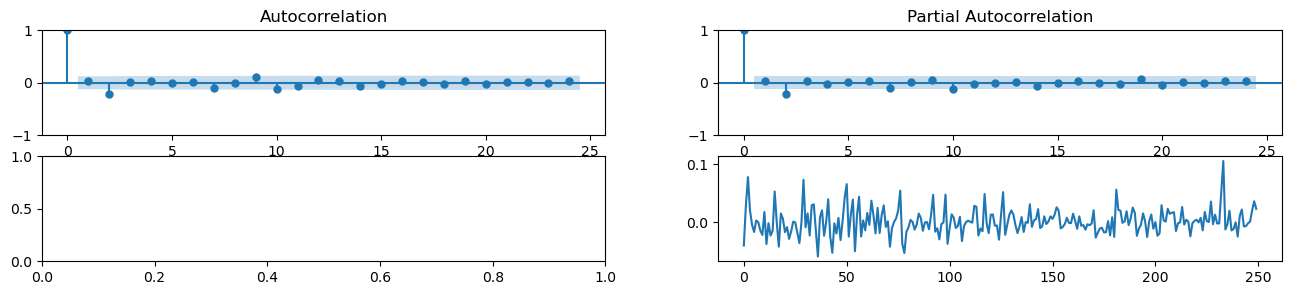

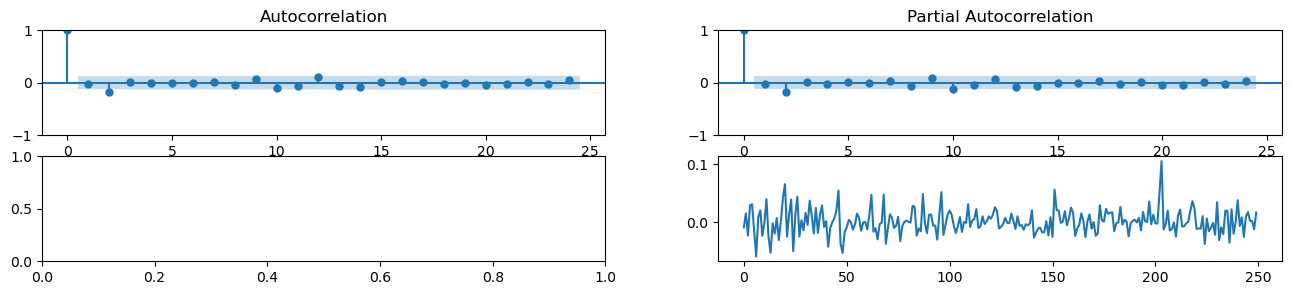

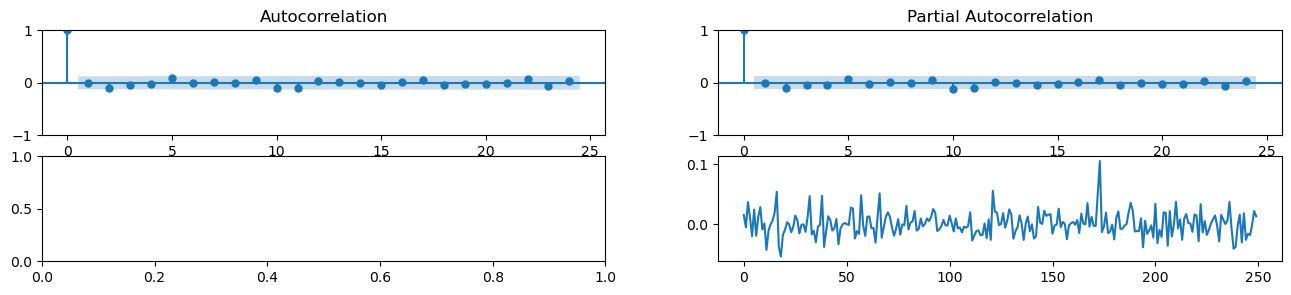

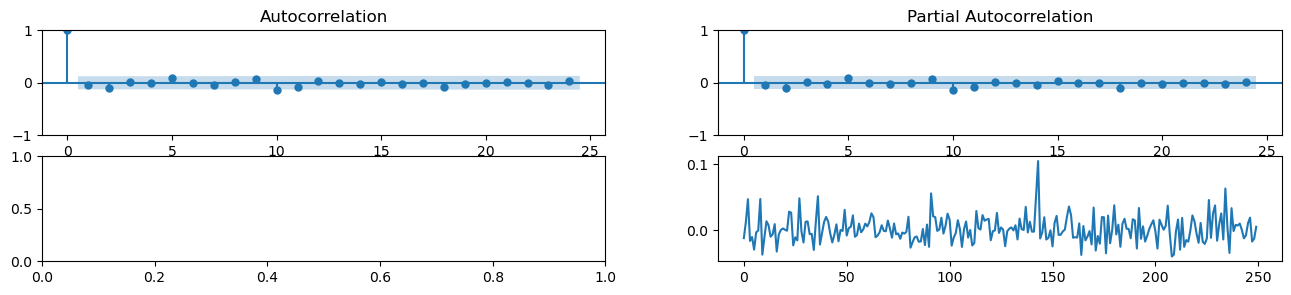

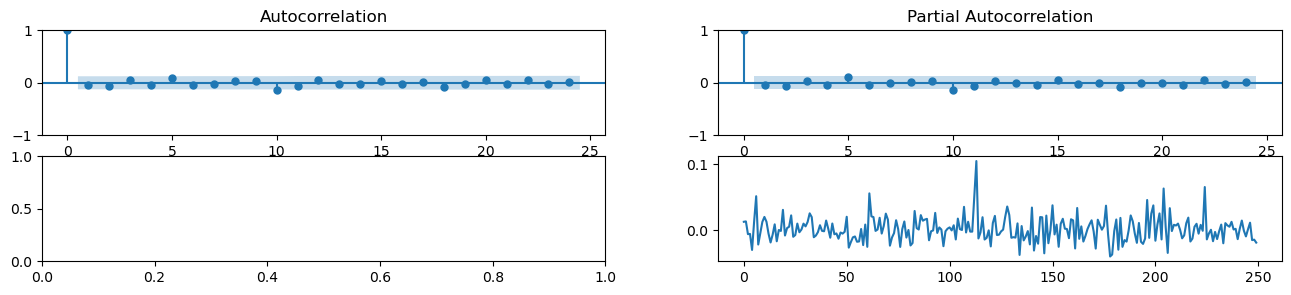

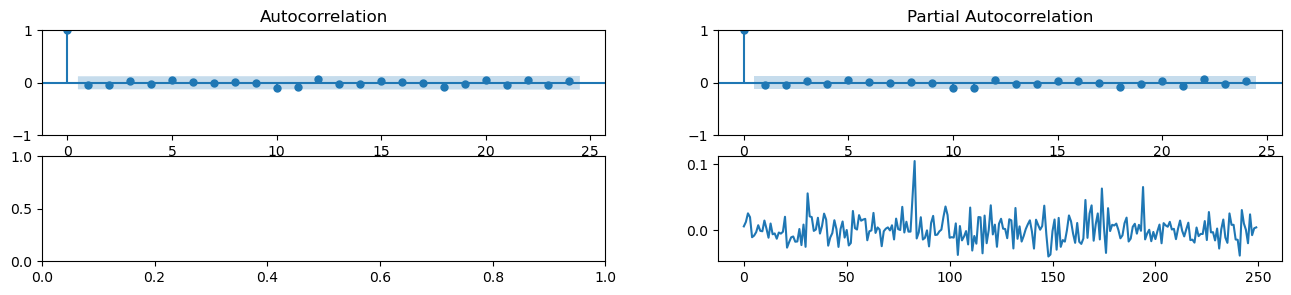

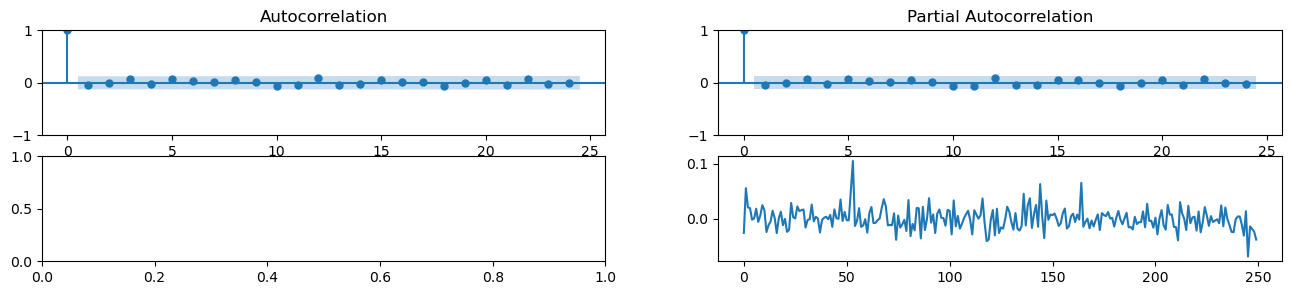

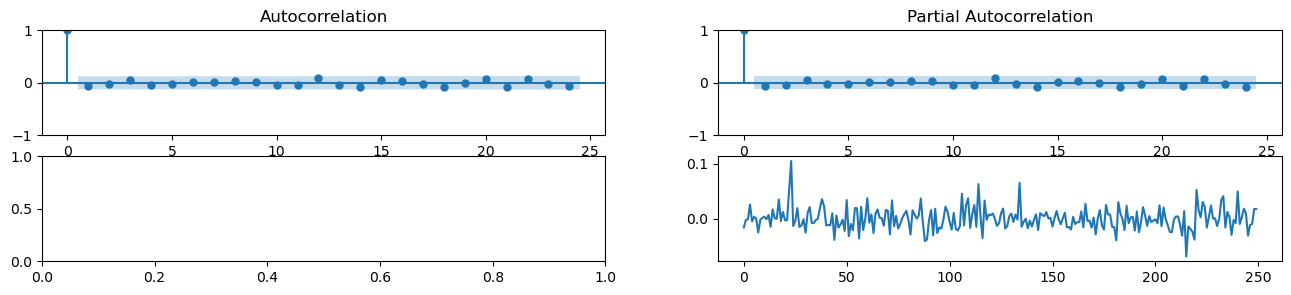

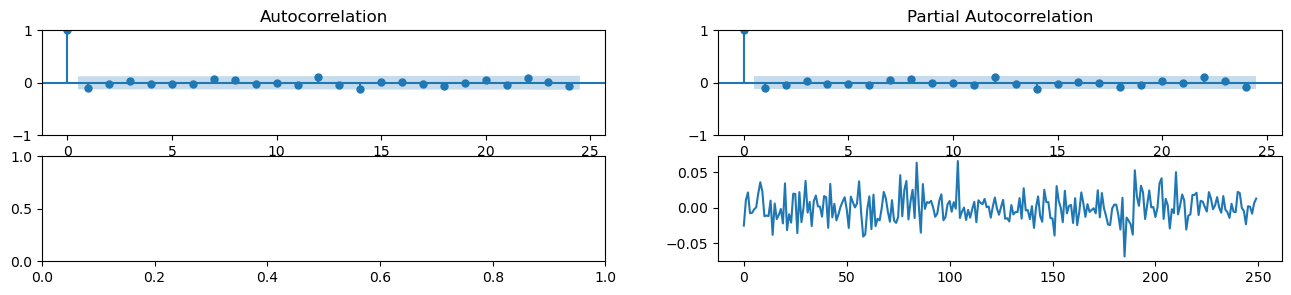

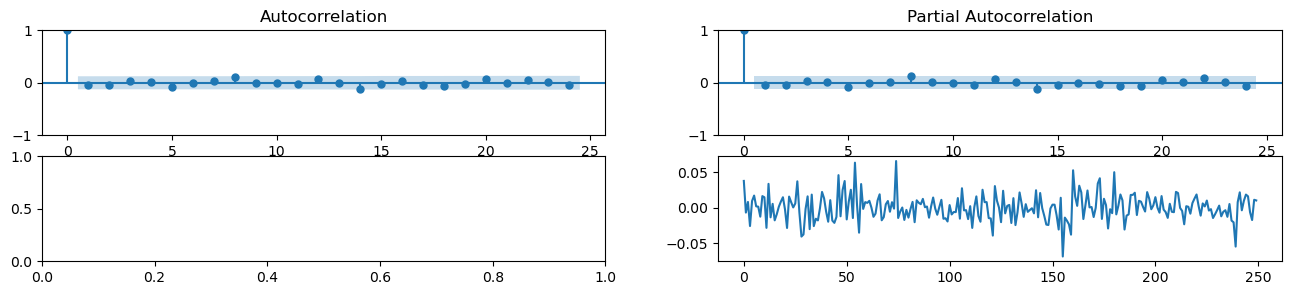

In [6]:
# series = encoding_indices.numpy()
# fig, axes = plt.subplots(2,2,figsize=(16,3), dpi= 100)
# plt.plot(series)
# plot_acf( series,  ax=axes[0,0])
# plot_pacf(series,  ax=axes[0, 1])
# plt.show()
for i in range(10):
    series = data[i,:,0]
    fig, axes = plt.subplots(2,2,figsize=(16,3), dpi= 100)
    plt.plot(series)
    plot_acf( series,  ax=axes[0,0])
    plot_pacf(series,  ax=axes[0, 1])
    plt.show()

    # plt.plot(data[i,:,0])
    # plt.show()
# x = data[0,:,0]
# x = np.expand_dims(x, axis=1)
# x.shape

## Modeling

In [7]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, latent_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = latent_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [51]:
def get_encoder(latent_dim=8):
    encoder_inputs = keras.Input(shape=(250, 1), name='encoder_input')
    x = layers.Conv1D(1, 3, activation="relu", strides=2, padding="valid", name='conv1d_1' )(encoder_inputs)
    x = layers.Conv1D(1, 3, activation="relu", strides=2, padding="same", name='conv1d_2')(x)
    encoder_outputs = layers.Conv1D(latent_dim, 3, activation="relu", strides=2, padding="valid", name='conv1d_3')(x)
    # x = layers.Conv1D(16, 3, activation="relu", strides=2, padding="same", name='conv1d_4')(x)
    # encoder_outputs = layers.Conv1D(latent_dim, 1, padding="same", name='conv1d_5')(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=8):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:], name='decoder_input')
    x = layers.Conv1DTranspose(16, 3, activation="relu", strides=2, padding="valid", output_padding =1, name='conv1d_tr_1')(
        latent_inputs
    )
    x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same",output_padding =1, name='conv1d_tr_2')(x)
    decoder_outputs = layers.Conv1DTranspose(1, 3, activation="relu", padding="valid", name='conv1d_tr_3')(x)
    # decoder_outputs = layers.Conv1DTranspose(1, 3, padding="same", name='conv1d_tr_3')(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [49]:
encoder = get_encoder()
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 250, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 124, 32)           128       
                                                                 
 conv1d_2 (Conv1D)           (None, 62, 16)            1552      
                                                                 
 conv1d_3 (Conv1D)           (None, 30, 8)             392       
                                                                 
Total params: 2072 (8.09 KB)
Trainable params: 2072 (8.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
decoder = get_decoder()
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 30, 8)]           0         
                                                                 
 conv1d_tr_1 (Conv1DTranspo  (None, 62, 16)            400       
 se)                                                             
                                                                 
 conv1d_tr_2 (Conv1DTranspo  (None, 124, 32)           1568      
 se)                                                             
                                                                 
 conv1d_tr_3 (Conv1DTranspo  (None, 124, 1)            97        
 se)                                                             
                                                                 
Total params: 2065 (8.07 KB)
Trainable params: 2065 (8.07 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

In [14]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(250, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae(16, 32).summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 1)]          0         
                                                                 
 encoder (Functional)        (None, 62, 16)            7376      
                                                                 
 vector_quantizer (VectorQu  (None, 62, 16)            512       
 antizer)                                                        
                                                                 
 decoder (Functional)        (None, 250, 1)            9409      
                                                                 
Total params: 17297 (67.57 KB)
Trainable params: 17297 (67.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
@keras.saving.register_keras_serializable()
class VQVAETrainer(keras.models.Model):
    def __init__(self, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)

        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) 
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [17]:
latent_dim = 16
num_embeddings = 128

In [18]:
vqvae_trainer = VQVAETrainer(latent_dim=latent_dim, num_embeddings=num_embeddings)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(data_gen, epochs=30)

Epoch 1/30


2023-07-26 14:22:05.640746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 5s 21ms/step - loss: 2.9938e-04 - reconstruction_loss: 2.0315e-04 - vqvae_loss: 6.8860e-05
Epoch 2/30
189/189 [==============================] - 4s 21ms/step - loss: 4.5750e-04 - reconstruction_loss: 1.2848e-04 - vqvae_loss: 3.0140e-04
Epoch 3/30
189/189 [==============================] - 4s 21ms/step - loss: 7.4015e-04 - reconstruction_loss: 1.3811e-04 - vqvae_loss: 5.9834e-04
Epoch 4/30
189/189 [==============================] - 4s 21ms/step - loss: 0.0016 - reconstruction_loss: 3.0667e-04 - vqvae_loss: 0.0013
Epoch 5/30
189/189 [==============================] - 4s 21ms/step - loss: 3.8637e-04 - reconstruction_loss: 5.8696e-05 - vqvae_loss: 3.2344e-04
Epoch 6/30
189/189 [==============================] - 4s 21ms/step - loss: 0.0033 - reconstruction_loss: 5.5605e-04 - vqvae_loss: 0.0027
Epoch 7/30
189/189 [==============================] - 4s 21ms/step - loss: 6.8710e-04 - reconstruction_loss: 1.0411e-04 - vqvae_loss: 5.7595e-04
Epoch 8/30
1

In [19]:
vqvae_trainer.save('vqvae_trainer_18072023.keras')

In [ ]:
# vqvae_trainer2 = keras.models.load_model('vqvae_trainer_18072023.keras')

In [20]:
vqvae_trainer.history.history.keys()

dict_keys(['loss', 'reconstruction_loss', 'vqvae_loss'])

In [21]:
loss = vqvae_trainer.history.history['loss']
reconstruction_loss= vqvae_trainer.history.history['reconstruction_loss']
vqvae_loss = vqvae_trainer.history.history['vqvae_loss']


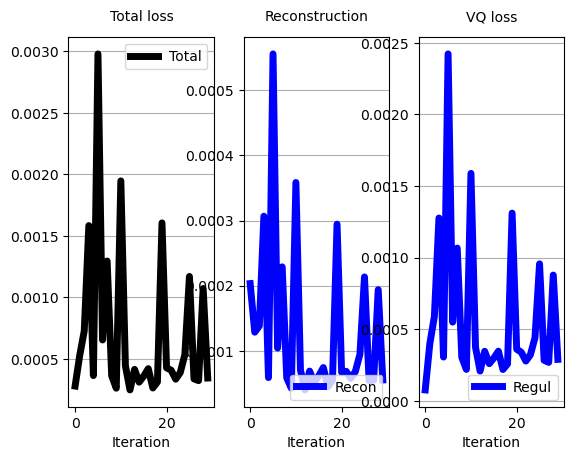

In [22]:
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

x_points = np.arange(0, len(loss), 1)
axes[0].set_title("Total loss", fontsize=10, y=1.022)
axes[0].plot(x_points, loss, color="black", label="Total", linewidth=5)
axes[0].yaxis.grid(True, zorder=0)
axes[0].set_xlabel('Iteration', fontsize=10)
axes[0].legend(loc='upper right')

axes[1].set_title("Reconstruction", fontsize=10, y=1.022)
axes[1].plot(x_points, reconstruction_loss, color="blue", label="Recon", linewidth=5)
axes[1].yaxis.grid(True, zorder=0)
axes[1].set_xlabel('Iteration', fontsize=10)
axes[1].legend(loc='lower right')

axes[2].set_title("VQ loss", fontsize=10, y=1.022)
axes[2].plot(x_points, vqvae_loss, color="blue", label="Regul", linewidth=5)
axes[2].yaxis.grid(True, zorder=0)
axes[2].set_xlabel('Iteration', fontsize=10)
axes[2].legend(loc='lower right')

plt.show()      

In [23]:
trained_vqvae_model = vqvae_trainer.vqvae

## Reconstruction

(250, 363)
(363, 250)
(363, 250, 1)
12/12 [==============================] - 0s 12ms/step
(363, 250, 1)


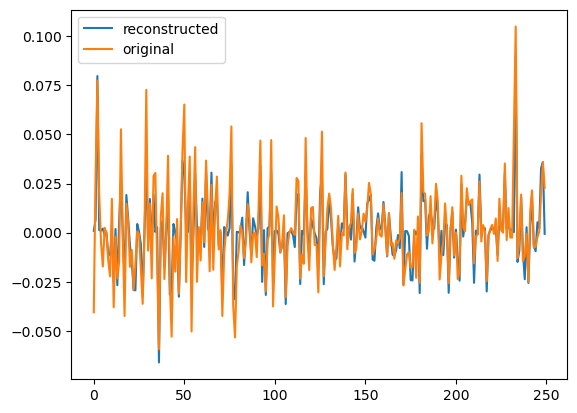

In [53]:
batch= data[0]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)
trained_vqvae_model = vqvae_trainer.vqvae
x_hat = trained_vqvae_model.predict(batch)
print(x_hat.shape)
plt.plot(x_hat[0, :], label='reconstructed')
plt.plot(batch[0, :], label='original')
plt.legend()
plt.show()

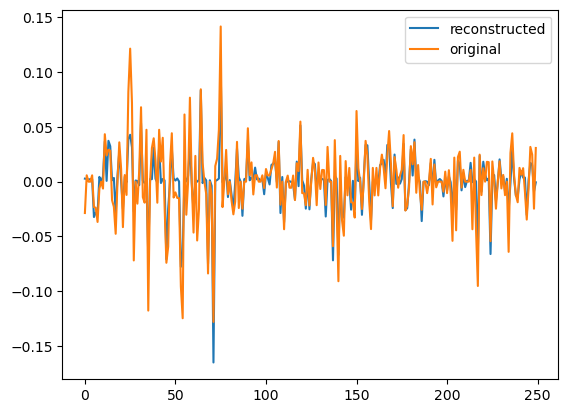

In [54]:
plt.plot(x_hat[30, :], label='reconstructed')
plt.plot(batch[30, :], label='original')
plt.legend()
plt.show()

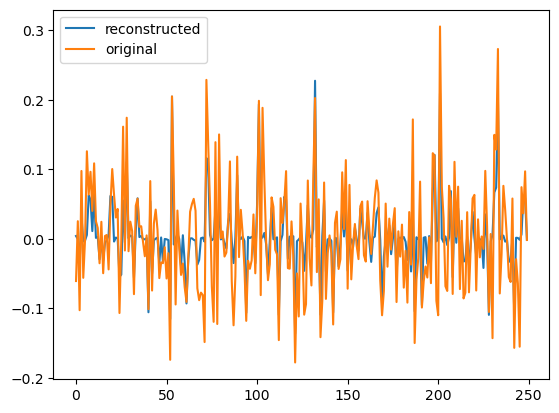

In [23]:
plt.plot(x_hat[300, :], label='reconstructed')
plt.plot(batch[300, :], label='original')
plt.legend()
plt.show()

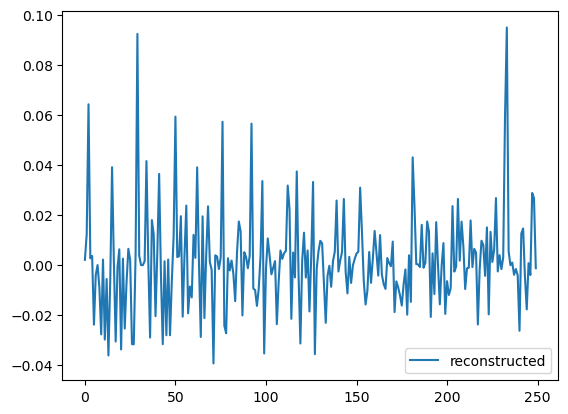

In [24]:
plt.plot(x_hat[0, :], label='reconstructed')
plt.legend()
plt.show()

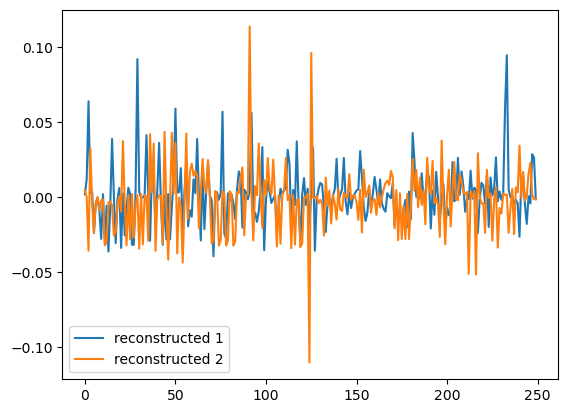

In [25]:
plt.plot(x_hat[0, :], label='reconstructed 1')
plt.plot(x_hat[40, :], label='reconstructed 2')
plt.legend()
plt.show()

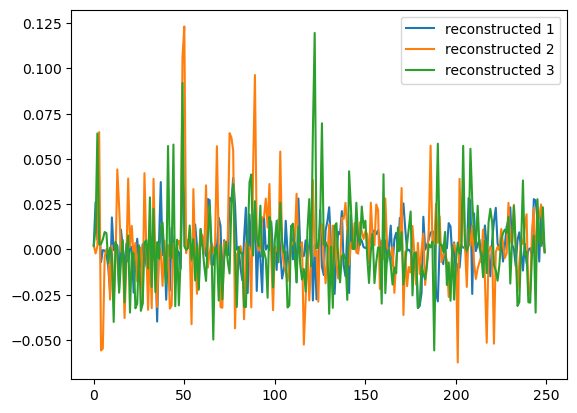

In [26]:
plt.plot(x_hat[20, :], label='reconstructed 1')
plt.plot(x_hat[10, :], label='reconstructed 2')
plt.plot(x_hat[100, :], label='reconstructed 3')
# plt.plot(x_hat[0, :], label='generated 5')
# plt.plot(x_hat[40, :], label='generated 6')
plt.legend()
plt.show()

In [246]:
batch= data[0]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)


(250, 363)
(363, 250)
(363, 250, 1)


In [247]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(batch)
print(encoded_outputs.shape)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
print(flat_enc_outputs.shape)
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

# for i in range(10):
#     plt.subplot(1, 2, 1)
#     plt.plot(batch[i] )
#     plt.title("Original")
#     # plt.axis("off")

#     plt.subplot(1, 2, 2)
#     plt.plot(codebook_indices[i])
#     plt.title("Code")
#     # plt.axis("off")
#     plt.show()

12/12 [==============================] - 0s 9ms/step
(363, 62, 16)
(22506, 16)


## Exploring the embedings

In [248]:
codebook_indices.shape


(363, 62)

In [249]:
embeddings = quantizer.embeddings
print(embeddings.shape)

(16, 128)


In [250]:
batch.shape

(363, 250, 1)

In [251]:
sample = np.expand_dims(batch[0],axis=0)

In [252]:
sample = np.expand_dims(batch[0],axis=0)
print(f'sample dim: {sample.shape}' )
encoded_outputs = encoder.predict(sample)

print(f'Encode output dim: {encoded_outputs.shape}')
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
print(f'Encode output dim flat: {flat_enc_outputs.shape}')
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
print(f'Codebook dim: {codebook_indices.shape}')
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f'Codebook dim: {codebook_indices.shape}')


sample dim: (1, 250, 1)
1/1 [==============================] - 0s 46ms/step
Encode output dim: (1, 62, 16)
Encode output dim flat: (62, 16)
Codebook dim: (62,)
Codebook dim: (1, 62)


In [253]:
flattened_inputs = flat_enc_outputs
print(f'Flattened input dim: {flattened_inputs.shape}')
print(f'Embeddings dim: {embeddings.shape}')
similarity = tf.matmul(flattened_inputs, embeddings)
print(f'Similarity dim: {similarity.shape}')
distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(embeddings ** 2, axis=0)
            - 2 * similarity
        )
print(f'Distances dim: {distances.shape}')
encoding_indices = tf.argmin(distances, axis=1)
print(f'Encoding indices dim: {encoding_indices.shape}')

Flattened input dim: (62, 16)
Embeddings dim: (16, 128)
Similarity dim: (62, 128)
Distances dim: (62, 128)
Encoding indices dim: (62,)


A embedding can be choose multiple times, and order of embeddings is also important for reconstruction.

In [254]:
encoding_indices

<tf.Tensor: shape=(62,), dtype=int64, numpy=
array([ 27,  39,  73,  11, 102, 119,  86, 122, 125,  58,  40,  73,  27,
        17, 105, 125,  17,  54,  92, 111, 117,  58,  92, 114,   0,  41,
       119,  48,  96,  40,   6,   0,  64,  39,  75,  75, 113,  48,  26,
        74,  22, 116,  18, 114,  38,  76,  63,  58,  98,  18,  45, 121,
        42,   8,  57,  53,  75,  92, 122,  34, 126,  80])>

In [263]:
encoding_indices

<tf.Tensor: shape=(62,), dtype=int64, numpy=
array([ 27,  39,  73,  11, 102, 119,  86, 122, 125,  58,  40,  73,  27,
        17, 105, 125,  17,  54,  92, 111, 117,  58,  92, 114,   0,  41,
       119,  48,  96,  40,   6,   0,  64,  39,  75,  75, 113,  48,  26,
        74,  22, 116,  18, 114,  38,  76,  63,  58,  98,  18,  45, 121,
        42,   8,  57,  53,  75,  92, 122,  34, 126,  80])>

In [257]:
num_embeddings = embeddings.shape[1]
# Quantization.
encodings = tf.one_hot(encoding_indices, num_embeddings)
print(f'Encodings dim: {encodings.shape}')
quantized = tf.matmul(encodings, embeddings, transpose_b=True)
print(f'Quantized dim: {quantized.shape}')
        # Reshape the quantized values back to the original input shape
quantized = tf.reshape(quantized, flattened_inputs.shape)
print(f'Quantized dim: {quantized.shape}')


Encodings dim: (62, 128)
Quantized dim: (62, 16)
Quantized dim: (62, 16)


### PLots

In [258]:
embeddings[:,0]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 0.00770594,  0.06125829,  0.03728676,  0.01382775, -0.03116685,
       -0.07145061, -0.07158235, -0.00477266,  0.03281674,  0.05190501,
        0.03778717, -0.06131311, -0.12862235, -0.06136201,  0.05825495,
        0.02176202], dtype=float32)>

Embeddings dim latent dim X Num embeddings : (16, 128)


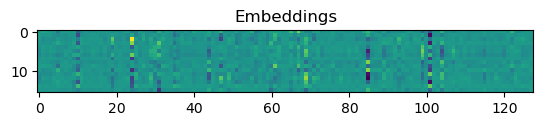

In [259]:

plt.imshow(embeddings)
plt.title("Embeddings")
print(f'Embeddings dim latent dim X Num embeddings : {embeddings.shape}')
plt.show()


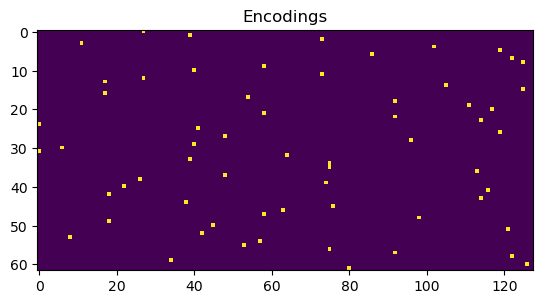

Encodings dim #vectors X Num embeddings : (62, 128)


In [260]:


plt.imshow(encodings)
plt.title("Encodings")
plt.show()
print(f'Encodings dim #vectors X Num embeddings : {encodings.shape}')

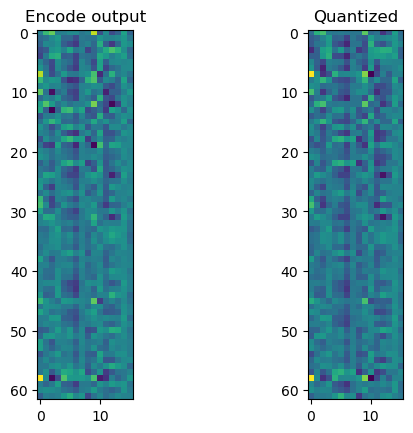

Encode output dim: (1, 62, 16)
Quantized dim: (62, 16)


In [261]:
plt.subplot(1, 2, 1)
plt.imshow(flattened_inputs)
plt.title("Encode output")
# plt.axis("off")


plt.subplot(1, 2, 2)
plt.imshow(quantized)
plt.title("Quantized")
# plt.axis("off")
plt.show()

print(f'Encode output dim: {encoded_outputs.shape}')
print(f'Quantized dim: {quantized.shape}')

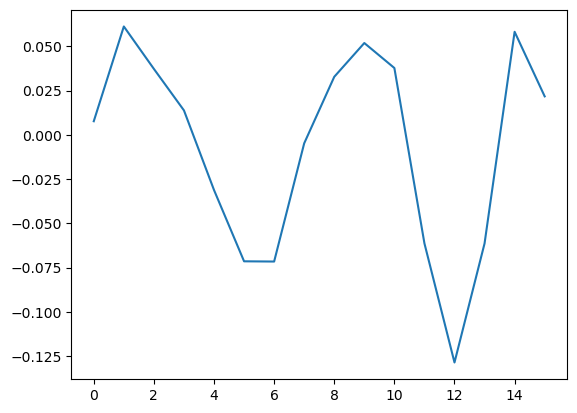

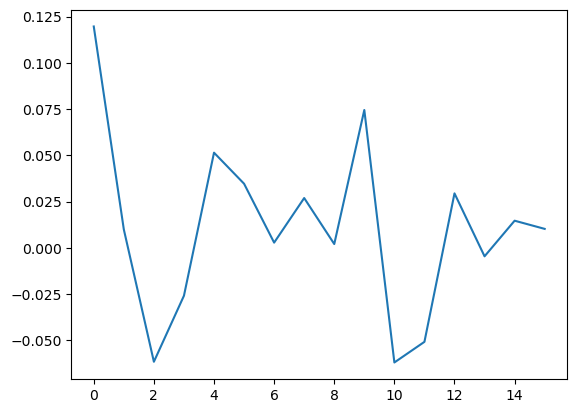

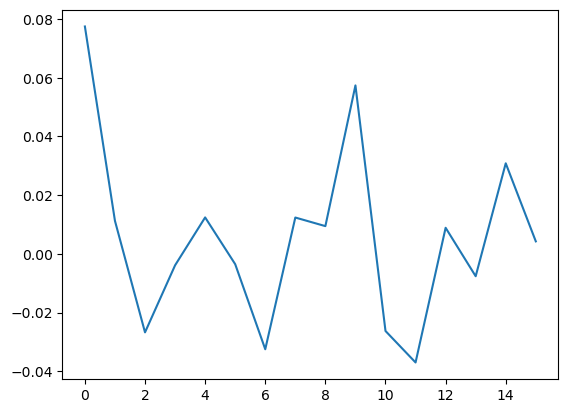

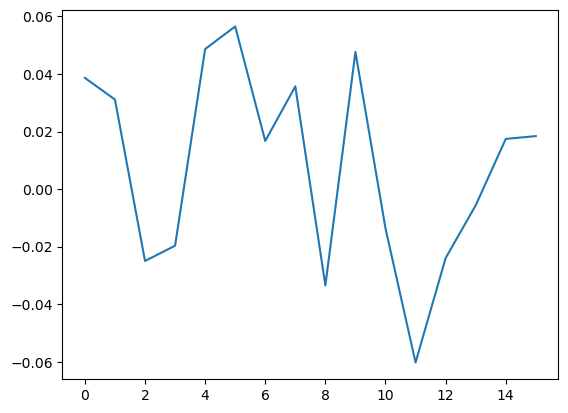

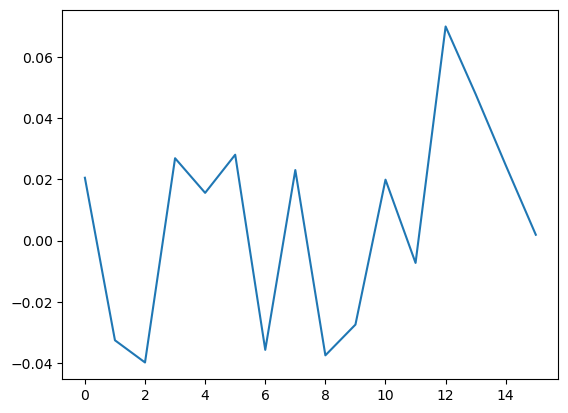

In [262]:
for i in range(5):
    plt.plot(embeddings[:, i])
    plt.show()


## Are the embedding codings an autoregressive time series ?? 

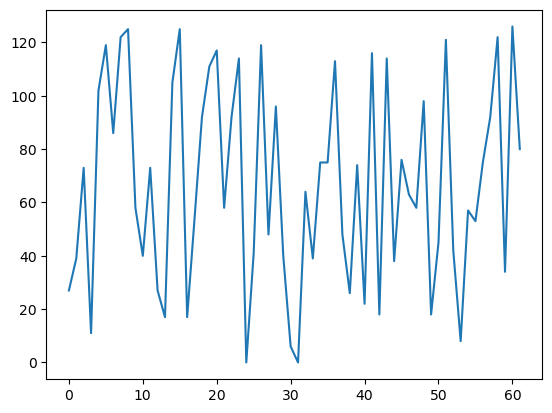

In [264]:
plt.plot(encoding_indices)

In [275]:
axes[0, 0]

<Axes: >

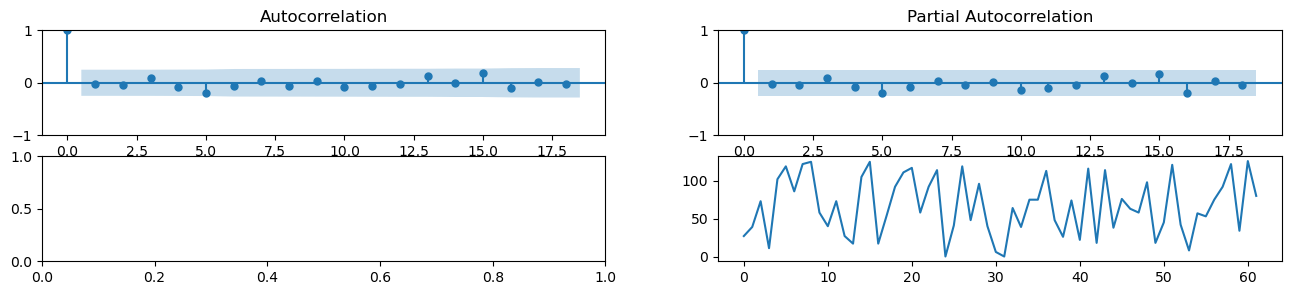

In [277]:
series = encoding_indices.numpy()
fig, axes = plt.subplots(2,2,figsize=(16,3), dpi= 100)
plt.plot(series, label='encoding indices')
plot_acf( series,  ax=axes[0,0])
plot_pacf(series,  ax=axes[0, 1])
plt.show()

## Reconstruct a full time series from embbedings 

##  Sampling no model

(1, 62)
Encodings dim: (1, 62, 128)
Quantized dim: (1, 62, 16)
Quantized dim: (62, 16)
Quantized dim: (1, 62, 16)
1/1 [==============================] - 0s 14ms/step
Generation dim: (1, 250, 1)


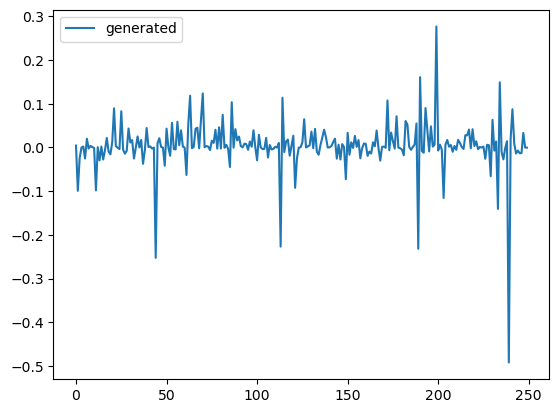

In [184]:
import random
x = [random.randint(1,num_embeddings) for x in range(62)]
x = np.array(x)
x = np.expand_dims(x, axis=0)
print(x.shape)
# Quantization.
encodings = tf.one_hot(x, num_embeddings)
print(f'Encodings dim: {encodings.shape}')
quantized = tf.matmul(encodings, embeddings, transpose_b=True)
print(f'Quantized dim: {quantized.shape}')
        # Reshape the quantized values back to the original input shape
quantized = tf.reshape(quantized, flattened_inputs.shape)
print(f'Quantized dim: {quantized.shape}')
quantized = np.expand_dims(quantized,axis=0)
print(f'Quantized dim: {quantized.shape}')
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generation = decoder.predict(quantized)
print(f'Generation dim: {generation.shape}')
plt.plot(generation[0], label='generated')
plt.legend()
plt.show()

## Sampling with Pixel CNN

In [279]:
batch= data[0]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)

encoded_outputs = encoder.predict(batch)
print(encoded_outputs.shape)

(250, 363)
(363, 250)
(363, 250, 1)
12/12 [==============================] - 0s 6ms/step
(363, 62, 16)


In [280]:
num_residual_blocks = 1
num_pixelcnn_layers = 1
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (62,)


In [238]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv1D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv1D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv1D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


In [239]:
pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
print(f"PixelCNN input shape: {pixelcnn_inputs.shape}")
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
print(f"OHE shape: {ohe.shape}")
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=15, activation="relu", padding="same"
)(ohe)
print(f"PixelCNN output shape: {x.shape}")

PixelCNN input shape: (None, 62)
OHE shape: (None, 62, 128)
PixelCNN output shape: (None, 62, 128)


In [240]:
ohe

<KerasTensor: shape=(None, 62, 128) dtype=float32 (created by layer 'tf.one_hot_13')>

In [241]:


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=15, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv1D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 62)]              0         
                                                                 
 tf.one_hot_14 (TFOpLambda)  (None, 62, 128)           0         
                                                                 
 pixel_conv_layer_39 (Pixel  (None, 62, 128)           245888    
 ConvLayer)                                                      
                                                                 
 residual_block_12 (Residua  (None, 62, 128)           49472     
 lBlock)                                                         
                                                                 
 pixel_conv_layer_41 (Pixel  (None, 62, 128)           16512     
 ConvLayer)                                                      
                                                         

In [141]:
batch= data[0]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)

(250, 363)
(363, 250)
(363, 250, 1)


In [142]:
# Generate the codebook indices.
encoded_outputs = encoder.predict(batch)
print(encoded_outputs.shape)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
print(flat_enc_outputs.shape)
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
print(codebook_indices.shape)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

12/12 [==============================] - 0s 2ms/step
(363, 62, 16)
(22506, 16)
(22506,)
Shape of the training data for PixelCNN: (363, 62)


In [143]:
codebook_indices.shape

(363, 62)

In [131]:
codebook_indices_all = np.empty((train_batches, stocks , 62 ))
codebook_indices_all.shape

(189, 363, 62)

In [132]:
for i, batch in enumerate(data): 
    # b= np.empty((stocks , length ))
    batch= np.transpose(batch)
    
    batch= np.expand_dims(batch, axis=2)
    encoded_outputs_all = encoder.predict(batch)
    flat_enc_outputs = encoded_outputs_all.reshape(-1, encoded_outputs_all.shape[-1])

    codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

    codebook_indices_all[i,:, :] = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
    

12/12 [==============================] - 0s 1ms/step


In [133]:
codebook_indices_all.shape

(189, 363, 62)

In [134]:
codebook_indices_all[0].shape

(363, 62)

In [144]:
codebook_indices.shape

(363, 62)

codebook_indices_all = codebook_indices_all.reshape(-1, codebook_indices_all.shape[-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices_all.shape}")

In [145]:
codebook_gen = CodeBookDataGen(codebook_indices_all)

Number of training batches:  189
Number of stocks:  363
Number of latent variables:  62


In [228]:
pixel_cnn.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    # codebook_gen,
    x = codebook_indices,
    y = codebook_indices,
    batch_size=128,
    epochs=10,
    validation_split=0.3
    )

Epoch 1/10


2023-07-25 16:33:22.636611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 357ms/step - loss: 4.8510 - accuracy: 0.0102 - val_loss: 4.8491 - val_accuracy: 0.0129
Epoch 2/10
1/2 [==============>...............] - ETA: 0s - loss: 4.8491 - accuracy: 0.0115

2023-07-25 16:33:23.225554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 115ms/step - loss: 4.8483 - accuracy: 0.0130 - val_loss: 4.8471 - val_accuracy: 0.0148
Epoch 3/10
2/2 [==============================] - 0s 58ms/step - loss: 4.8457 - accuracy: 0.0149 - val_loss: 4.8449 - val_accuracy: 0.0154
Epoch 4/10
2/2 [==============================] - 0s 61ms/step - loss: 4.8429 - accuracy: 0.0165 - val_loss: 4.8425 - val_accuracy: 0.0164
Epoch 5/10
2/2 [==============================] - 0s 55ms/step - loss: 4.8400 - accuracy: 0.0180 - val_loss: 4.8398 - val_accuracy: 0.0164
Epoch 6/10
2/2 [==============================] - 0s 55ms/step - loss: 4.8368 - accuracy: 0.0196 - val_loss: 4.8368 - val_accuracy: 0.0178
Epoch 7/10
2/2 [==============================] - 0s 60ms/step - loss: 4.8333 - accuracy: 0.0203 - val_loss: 4.8334 - val_accuracy: 0.0191
Epoch 8/10
2/2 [==============================] - 0s 63ms/step - loss: 4.8293 - accuracy: 0.0213 - val_loss: 4.8294 - val_accuracy: 0.0194
Epoch 9/10
2/2 [=====================

In [229]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
print(inputs.shape)
outputs = pixel_cnn(inputs, training=False)
print(outputs.shape)

(None, 62)
(None, 62, 128)


In [230]:

categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
print(outputs.shape)
sampler = keras.Model(inputs, outputs)
print(sampler.summary())

(None, 62)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 62)]              0         
                                                                 


 pixel_cnn (Functional)      (None, 62, 128)           328384    
                                                                 
 distribution_lambda_6 (Dis  ((None, 62),              0         
 tributionLambda)             (None, 62))                        
                                                                 
Total params: 328384 (1.25 MB)
Trainable params: 328384 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [231]:
# Create an empty array of priors.
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
print(f"Prior shape: {priors.shape}")
batch, rows = priors.shape


Prior shape: (10, 62)


In [232]:
priors[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [233]:
probs = sampler.predict(priors)
print(probs.shape)

probs[0, :]

1/1 [==============================] - 0s 152ms/step
(10, 62)


2023-07-25 16:33:35.154444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([  8,  22,  94,  33,  60,  32,  29,  31, 106,  70,  59,  39,  51,
         4, 113,  32,  39,  97,  98, 100,  31,  80, 119,  85,  75,  76,
       117, 102, 109,  11, 109,  32,  85,  40,   7,  79,  97,  22,  78,
        10,  89, 104,  24,  87,  32,  56,  53,  32,   5,  19, 112,  46,
        86,  41, 122,  35,  77, 109,  93,  63,  99,  18], dtype=int32)

In [234]:

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):

    # Feed the whole array and retrieving the pixel value probabilities for the next
    # pixel.
    print(f'Row: {row}')

    # print(priors[0, row:-1], priors[0, row:-1].shape)
    probs = sampler.predict(priors)
    # Use the probabilities to pick pixel values and append the values to the priors.
    priors[:, row] = probs[:, row]
    print('Prior',priors[0, :row], priors[0, :row].shape )
    print('Prior',priors[0, row:-1], priors[0, row:-1].shape )
    print('Probs',probs[0, :row+1], probs[0, :row-1].shape )
    print('Probs',probs[0, row:-1], probs[0, row:-1].shape )

print(f"Prior shape: {priors.shape}")

Row: 0
1/1 [==============================] - 0s 28ms/step
Prior [] (0,)
Prior [89.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.] (61,)
Probs [89] (61,)
Probs [ 89 117  30  87 112  24  48  79  94 108  24  60 124  32  80   3  24  63
  19  68  30  41 116  33   4 120 125 120 117 104  49 104   7   0 124  75
  11  27  79  32  30  84 121  24  31  79 102 126  18  92  27  85  75  26
  70  90  89  17  74 127   8] (61,)
Row: 1
1/1 [==============================] - 0s 19ms/step
Prior [89.] (1,)
Prior [110.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.] 

In [235]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)



1/1 [==============================] - 0s 17ms/step


In [236]:
priors

array([[ 89., 110.,   7.,  73.,  54.,  78.,  90.,  93.,  84., 114., 105.,
         45.,  18.,  32.,  53.,  88.,  71.,  62.,  49., 105.,  10., 103.,
         10.,  40.,  25.,  51., 122.,  78.,  25.,  83.,  14., 114.,   7.,
         38.,  97., 126.,  44.,  56.,  22.,   7.,  75., 117.,  28.,  74.,
          6., 122., 112.,   8.,  18.,  97.,  31.,  55.,  13.,   4.,  42.,
          0.,  22.,  98.,  42., 123.,  67., 124.],
       [ 73.,  78.,  81.,  49.,  51.,  11.,  71.,  18., 125.,  78.,  62.,
        121., 122.,  18., 111.,  28.,  15.,  35.,  65.,   8.,  30.,  98.,
         37., 108.,  73., 111.,  65.,  61.,  26.,   6.,  10.,  45.,  13.,
         80.,  35.,  38.,  21.,  90., 110.,  44., 105.,  96.,  20.,   2.,
         85.,  33.,  90.,  69., 121.,   1.,  73.,  84.,  14.,  95., 121.,
         72.,  19.,  39.,  17.,  92.,  85.,   4.],
       [ 48.,  70.,  64., 115.,  57., 127.,  70.,  96.,  97.,  28.,  57.,
         17.,  22.,  96.,  29., 109.,  20.,  25.,  59.,  90.,  27.,  88.,
         8

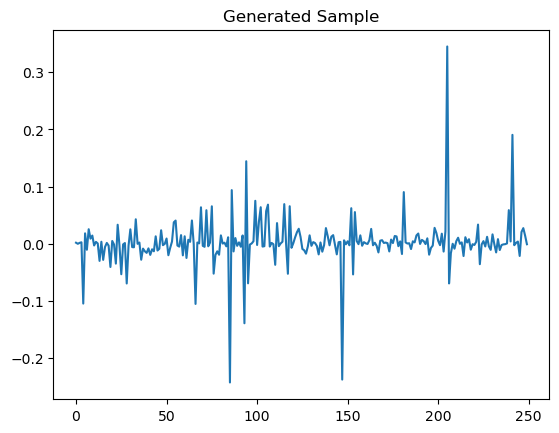

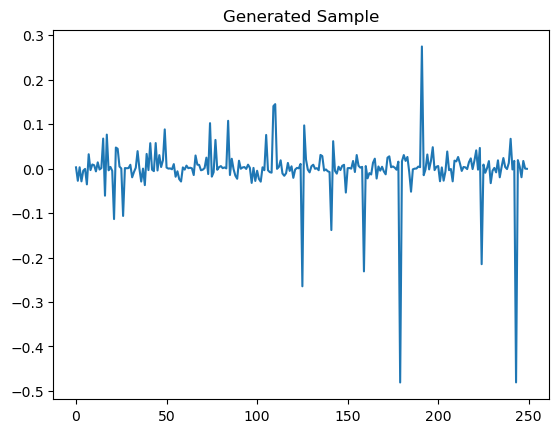

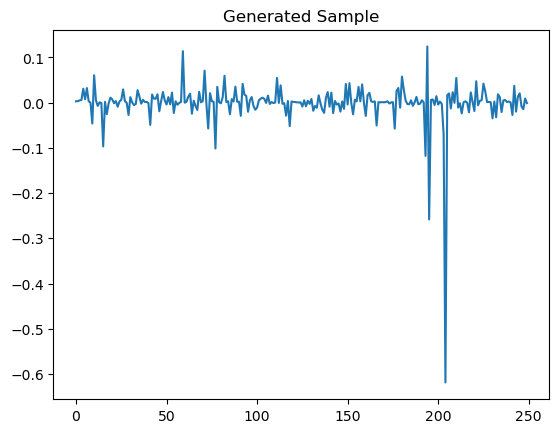

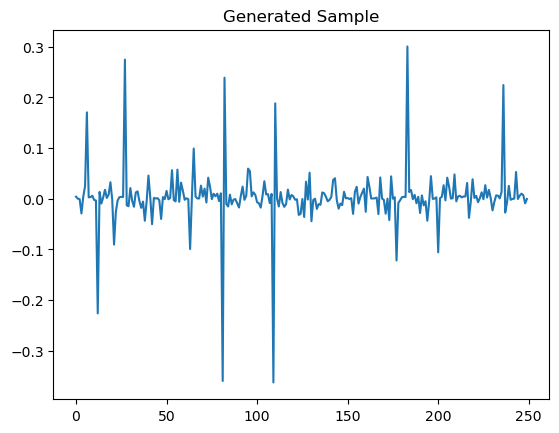

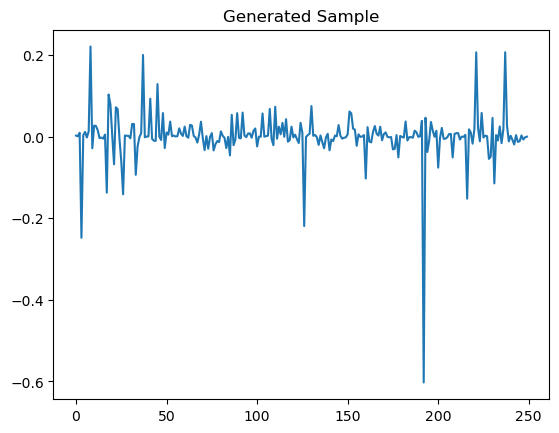

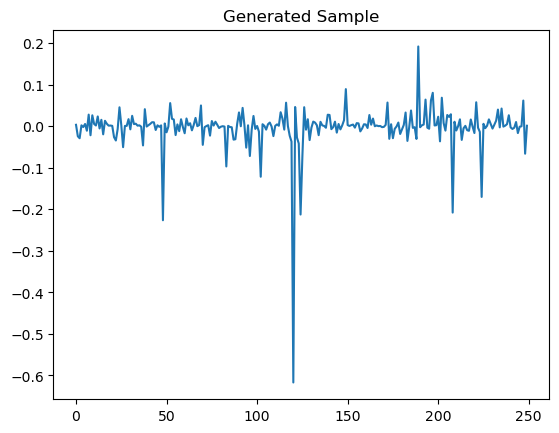

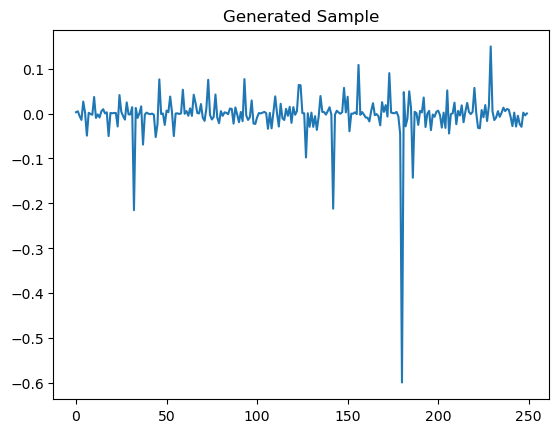

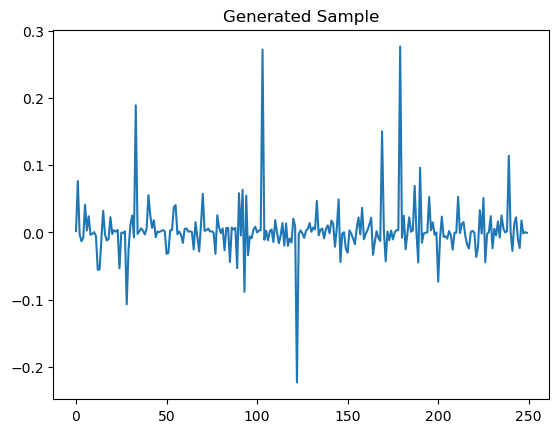

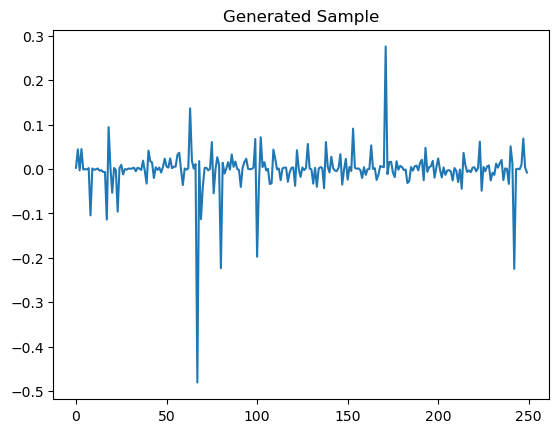

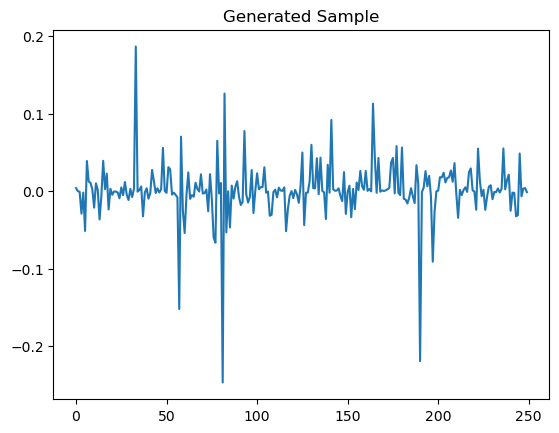

In [237]:
for i in range(batch):

    plt.plot(generated_samples[i])
    plt.title("Generated Sample")

    plt.show()

## Cluster the embeddings

In [152]:
batch= data[0]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)

(250, 363)
(363, 250)
(363, 250, 1)


In [153]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(batch)
print(encoded_outputs.shape)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
print(flat_enc_outputs.shape)
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
print(f"Shape of the code indices: {codebook_indices.shape}")

12/12 [==============================] - 0s 2ms/step
(363, 62, 16)
(22506, 16)
Shape of the code indices: (22506,)


In [167]:
num_embeddings = embeddings.shape[1]
# Quantization.
encodings = tf.one_hot(codebook_indices, num_embeddings)
print(f'Encodings dim: {encodings.shape}')
quantized = tf.matmul(encodings, embeddings, transpose_b=True)
print(f'Quantized dim: {quantized.shape}')
        # Reshape the quantized values back to the original input shape
quantized = tf.reshape(quantized, encoded_outputs.shape)
print(f'Quantized dim: {quantized.shape}')


Encodings dim: (22506, 128)
Quantized dim: (22506, 16)
Quantized dim: (363, 62, 16)


In [168]:
quantized = np.array(quantized)


In [174]:
quantized = quantized.reshape(quantized.shape[0],-1 )
print(quantized.shape)

(363, 992)


In [183]:
import pickle
with open("companies_362", "rb") as fp:   # Unpickling
   companies = pickle.load(fp)

In [188]:
from scipy.cluster.hierarchy import dendrogram, linkage 

linked = linkage(quantized,  'average', metric='cosine')
plt.figure(figsize=(300,150))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, labels=companies, leaf_font_size=20)
plt.savefig('cluster.png', format='png', bbox_inches='tight')
plt.savefig('cluster.jpg', format='jpg', bbox_inches='tight')

In [181]:
linked.shape

(362, 4)